In [2]:
import sys 
sys.path.append('../')
from core.ranking_utils import * 
import itertools 
from core.pse import pseudo_embedding
import scipy 
from core.tensor_label_model_pse import TensorLabelModelPSE
import scipy

from core.exp_label_model import * 
from core.pse import pseudo_embedding 
import matplotlib.pyplot as plt 

In [4]:
def get_errors(D):
  D = D**2
  n = D.shape[0]
  err = np.zeros(n-1)
  for dim in range(1,n):
      X, tk = pseudo_embedding(D, dim=dim)
      
      rec = np.zeros((n, n))
      for i in range(n):
          for j in range(n):
              rec[i,j] = np.abs(np.linalg.norm(X[i,:tk]-X[j,:tk])**2 - np.linalg.norm(X[i,tk:]-X[j,tk:])**2)
              if i != j:
                  err[dim-1] += np.abs((np.sqrt(D[i,j])-np.sqrt(rec[i,j])))/np.sqrt(D[i,j])
                  #err += np.abs((np.sqrt(D[i,j])-np.sqrt(rec[i,j])))/np.sqrt(D[i,j])
      err[dim-1]/= (n*(n-1))
      #err/= (n*(n-1))
  return err

In [7]:
lst_unq_rankings = [ Ranking(list(x)) for x in itertools.permutations(list(range(4)))]
r_utils =  RankingUtils(4)
D = r_utils.get_pair_wise_dists(lst_unq_rankings)

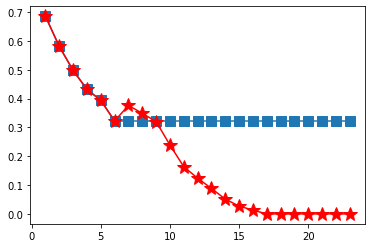

In [8]:

errs_square = get_errors(D)
mds_errs_square = errs_square[:6].tolist() + [errs_square[5]]*(len(errs_square)-6)
plt.plot(list(range(1,len(mds_errs_square)+1)), mds_errs_square, marker='s',markersize=10,label='MDS')
errs_square2 = errs_square.tolist() #+ [errs_square[2]]
plt.plot(list(range(1,len(errs_square2)+1)), errs_square2,marker='*',markersize=15,color='red',label='PSE')


In [5]:
from core.exp_label_model import * 
from core.pse import pseudo_embedding 
def dist_fun_0_1(y_1,y_2):
    return int(y_1 != y_2)
from core.tensor_label_model_euclidean import TensorLabelModelEuclidean

def run_tensor_lm_1_hot(L,Y,k,abstain_allowed=False):
    
    Y_emb_unique = np.eye(k)[[np.arange(k)]].squeeze()

    print(Y_emb_unique.shape)
    L_emb =[[Y_emb_unique[l,:] for l in L_i] for L_i in L]
    L_emb = np.array(L_emb)
    L_emb.shape 
    tlm = TensorLabelModelEuclidean(k,Y_emb_unique)
    tlm.k = k
    
    tlm.mu_recovery(L_emb,Y_emb_unique,0,1,2)
    
    Y_hat = tlm.predict(L_emb,abstain_allowed)
    accuracy = np.sum(Y_hat == Y) / Y.shape[0]
    print('Label model accuracy of tensor lm 1-hot: {}%'.format(int(100 * accuracy)))
    return accuracy

#run_tensor_lm_1_hot(L,y_centers,k)

def run(n_samples,theta):

    lst_unq_rankings = [ Ranking(list(x)) for x in itertools.permutations(list(range(4)))]
    r_utils =  RankingUtils(4)
    D_rankings = r_utils.get_pair_wise_dists(lst_unq_rankings)
    D = D_rankings*D_rankings
    
    k = len(D)
    space= np.arange(0,k,1)

    exp_model = ExponentialLabelModel()
    P = exp_model.get_probability_table_true(space, theta, D)

    Y = np.array([np.random.randint(k) for i in range(n_samples)])

    L = exp_model.draw_samples(Y)
    L = np.array(L)
    L = L.squeeze()

    acc_mv = run_mv(L,Y)
    acc_1_hot = run_tensor_lm_1_hot(L,Y,k)
    acc_pse =  run_tensor_lm_pse(L,Y,D,k,dim=16)
    return acc_mv,acc_pse,acc_1_hot


def run_mv(L,Y):
    mv_out  = scipy.stats.mode(L, axis=0)[0].squeeze()
    accuracy = np.sum(mv_out == Y) / Y.shape[0]
    print('Majority vote accuracy: {}%'.format(int(100 * accuracy)))
    return accuracy 

def run_tensor_lm_pse(L,Y,D,k,dim=3):

    Y_emb_unique, tk = pseudo_embedding(D, dim)

    L_emb =[[Y_emb_unique[l,:] for l in L_i] for L_i in L]
    L_emb = np.array(L_emb)
    L_emb.shape

    tlm = TensorLabelModelPSE(k,Y_emb_unique,tk)
    tlm.k = k
    tlm.mu_recovery(L_emb,0,1,2)

    Y_hat = tlm.predict(L_emb)

    accuracy = np.sum(Y_hat == Y) / Y.shape[0]

    print('Label model accuracy of tensor lm pse: {}%'.format(int(100 * accuracy)))
    return accuracy 


In [6]:
n = 2000
theta = np.array([4,0.6,0.5])
out = []
for t in range(2):
    o1,o2,o3 = run(n,theta)
    out.append([o1,o2,o3])
    print(out )

/tmp/ipykernel_178724/2177793434.py:53: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mv_out  = scipy.stats.mode(L, axis=0)[0].squeeze()


Majority vote accuracy: 63%
(24, 24)
(24, 2000) (24, 2000) (24, 2000)
(3, 24, 24) (24, 24)
Label model accuracy of tensor lm 1-hot: 59%
pos shape (24, 6)
neg shape (24, 10)
(6, 2000) (6, 2000) (6, 2000)
(3, 2000, 10)
(10, 2000) (10, 2000) (10, 2000)
[0.30860618 0.28570713 0.36505569 0.4016741  3.30340086 0.37204976
 0.25139538 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
Label model accuracy of tensor lm pse: 86%
[[0.636, 0.8615, 0.596]]
Majority vote accuracy: 63%
(24, 24)
(24, 2000) (24, 2000) (24, 2000)
(3, 24, 24) (24, 24)
Label model accuracy of tensor lm 1-hot: 58%
pos shape (24, 6)
neg shape (24, 10)
(6, 2000) (6, 2000) (6, 2000)
(3, 2000, 10)
(10, 2000) (10, 2000) (10, 2000)
[0.34013877 0.36957142 0.40697393 0.57325833 1.14305221 0.40558923
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.      